In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
train_df = pd.DataFrame({"file" : os.listdir("/content/drive/MyDrive/shape_figure/train")})
train_df["label"] = train_df["file"].apply(lambda x: x.split(".")[0])
train_df["label"] = train_df["label"].str.split("_").str.get(0)

train_df

,file,label
0,rec_28.jpg,rec
1,rec_652.jpg,rec
2,rec_470.jpg,rec
3,star_558.jpg,star
4,cir_427.jpg,cir
...,...,...
596,star_568.jpg,star
597,star_27.jpg,star
598,star_6.jpg,star
599,rec_44.jpg,rec


In [ ]:
test_df = pd.DataFrame({"file" : os.listdir("/content/drive/MyDrive/shape_figure/test")})

test_df.head()

,file
0,140.jpg
1,102.jpg
2,134.jpg
3,153.jpg
4,130.jpg


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df,
                                        test_size = 0.2,
                                        stratify = train_df["label"],

                                        random_state = 13)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [ ]:
FILES = "/content/drive/MyDrive/shape_figure/train/"
batch_size = 30
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = FILES,
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13
)

Found 480 validated image filenames belonging to 4 classes.


In [ ]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = FILES,
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13,
    shuffle = False
)

Found 121 validated image filenames belonging to 4 classes.


In [ ]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False
)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.layers import GlobalAveragePooling2D


def vgg16_pretrained():

    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(100, activation = "relu"),
            Dropout(0.4),
            Dense(64, activation = "relu"),
            Dense(4, activation = "softmax")
        ]
    )

    return model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = "accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                        

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    patience = 2,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.000000001
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max"
)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True
)

In [ ]:
history = model.fit(
    train_generator,
    epochs = 200,
    validation_data = val_generator,
    validation_steps = val_data.shape[0] // batch_size,
    steps_per_epoch = train_data.shape[0] // batch_size,
    callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.6876 - accuracy: 0.4646
Epoch 1: val_accuracy improved from -inf to 0.69167, saving model to catdog_vgg16_.01-0.691667.hdf5
16/16 [==============================] - 39s 2s/step - loss: 1.6876 - accuracy: 0.4646 - val_loss: 0.6882 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.7021
Epoch 2: val_accuracy improved from 0.69167 to 0.80000, saving model to catdog_vgg16_.02-0.800000.hdf5
16/16 [==============================] - 26s 2s/step - loss: 0.7897 - accuracy: 0.7021 - val_loss: 0.4840 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7812
Epoch 3: val_accuracy improved from 0.80000 to 0.85833, saving model to catdog_vgg16_.03-0.858333.hdf5
16/16 [==============================] - 28s 2s/step - loss: 0.5776 - accuracy: 0.7812 - val_loss: 0.3757 - val_accuracy: 0.8583

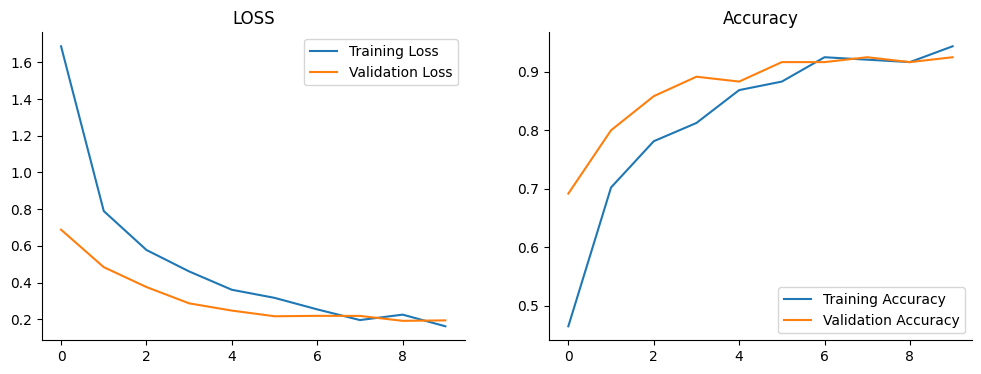

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"], ax = axes[0],
             label = "Training Loss" )
sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"], ax = axes[0],
             label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"], ax = axes[1],
             label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"], ax = axes[1],
             label = "Validation Accuracy")
axes[0].set_title("LOSS");axes[1].set_title("Accuracy")

sns.despine()
plt.show()


In [ ]:
val_pred = model.predict(val_generator, steps=np.ceil(val_data.shape[0] / batch_size))
val_data["val_pred"] = np.argmax(val_pred, axis=1)

labels = {v: k for k, v in val_generator.class_indices.items()}

val_data["val_pred"] = val_data["val_pred"].map(labels)

5/5 [==============================] - 4s 602ms/step


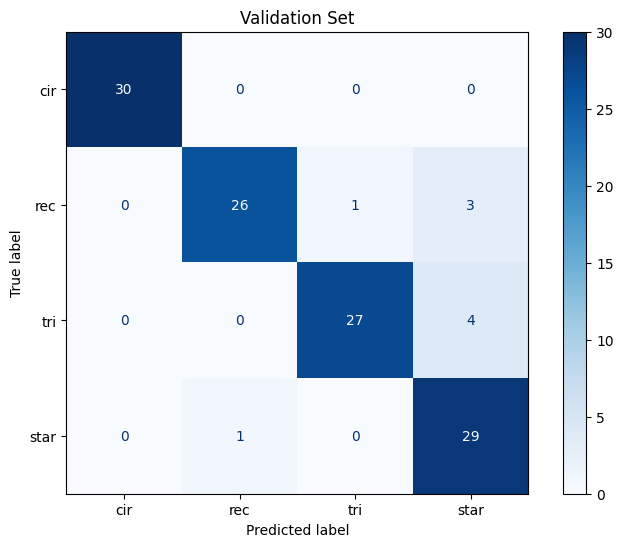

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cir", "rec", "tri", "star"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()

In [ ]:
val_errors = val_data[(val_data.label) != (val_data.val_pred)].reset_index(drop = True)
val_errors

,file,label,val_pred
0,star_48.jpg,star,tri
1,star_50.jpg,star,tri
2,star_49.jpg,star,tri
3,rec_696.jpg,rec,star
4,rec_666.jpg,rec,tri
5,rec_692.jpg,rec,tri
6,tri_738.jpg,tri,rec
7,rec_678.jpg,rec,tri
8,star_800.jpg,star,tri


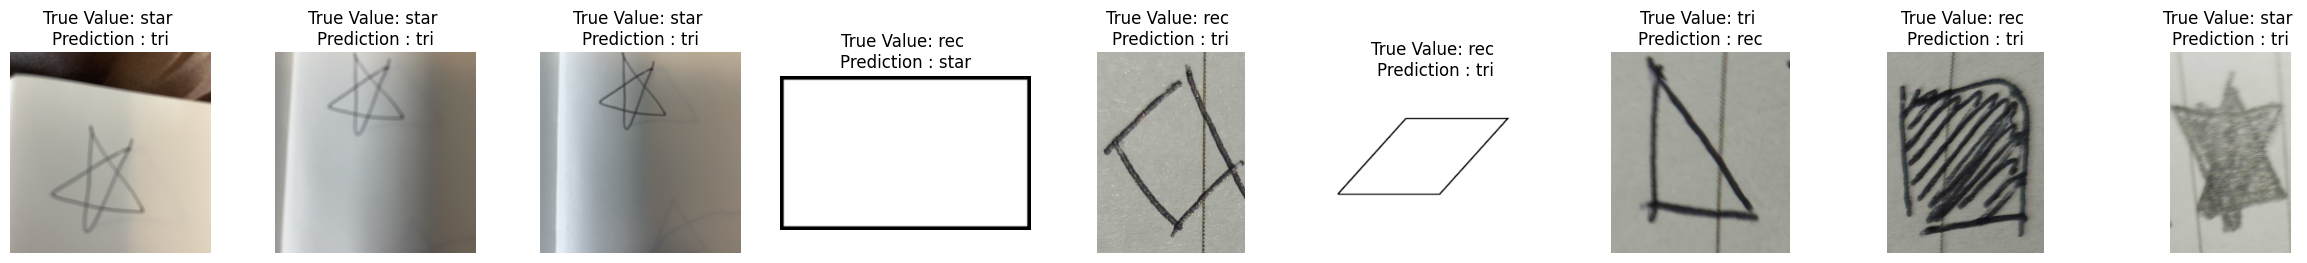

In [ ]:
fig = plt.figure(1, figsize = (24, 20))
for i in range(81):
    if i == len(val_errors):
        break
    plt.subplot(9, 9, i + 1)
    image = plt.imread("/content/drive/MyDrive/shape_figure/train/" + val_errors.file[i])
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True Value: {val_errors['label'][i]} \nPrediction : {val_errors['val_pred'][i]}")

plt.tight_layout()
plt.show()